Импорт библиотек

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib

Загрузка данных и обработка данных

In [3]:
df = pd.read_csv('../data/price_data.csv')

df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

train_weekly = df.resample('W-MON').mean()

Создаем дополнительные признаки

In [4]:
train_weekly['Moving_Avg'] = train_weekly['Цена на арматуру'].rolling(window=4).mean()
train_weekly.dropna(inplace=True)

Разделение на `X` и `y`, разделение на train/test

In [5]:
X = train_weekly[['Цена на арматуру', 'Moving_Avg']]
y = train_weekly['Цена на арматуру']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Обучение модели XGBoost

In [6]:
xgb_model = XGBRegressor(n_estimators=2000, max_depth=4, learning_rate=0.03, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

Прогнозирование

In [7]:
y_pred = xgb_model.predict(X_test)

Прогноз на ближайшие недели

In [8]:
future_X = X_test[-1:].copy()
predicted_prices = []
for _ in range(4):  # Прогнозируем на 4 недели вперед
    next_pred = xgb_model.predict(future_X)[0]
    predicted_prices.append(next_pred)
    future_X.iloc[0, 0] = next_pred  # Обновляем цену
    future_X.iloc[0, 1] = np.mean(predicted_prices[-4:])  # Обновляем скользящее среднее

Принятие решения на основе прогноза

In [9]:
if predicted_prices[0] > y_test.iloc[-1]:  # Цена через неделю выше текущей
    tender_weeks = 3  # Закупаем на 3 недели
elif predicted_prices[0] < y_test.iloc[-1]:  # Цена через неделю ниже
    tender_weeks = 1  # Закупаем на 1 неделю
else:
    tender_weeks = 2  # Закупаем на 2 недели, если цена стабильна

print(f'Рекомендованный объем тендера: {tender_weeks} недель.')

Рекомендованный объем тендера: 1 недель.


Оценка модели

In [10]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Absolute Error (MAE): 907.0911305147059
Mean Squared Error (MSE): 2057271.2638048958
Root Mean Squared Error (RMSE): 1434.3190941366206
R-squared (R2): 0.9840942167612202


Визуализация

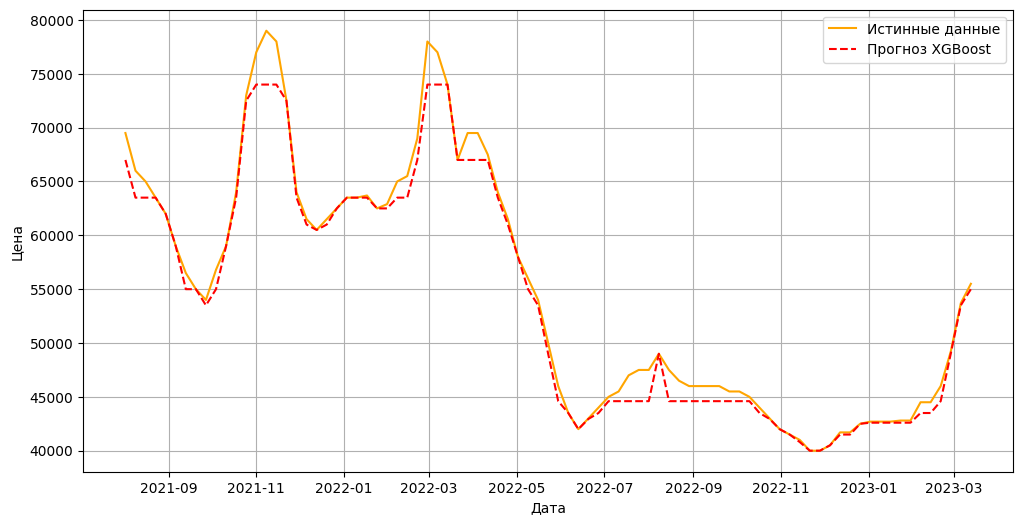

In [11]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Истинные данные', color='orange')
plt.plot(y_test.index, y_pred, label='Прогноз XGBoost', linestyle='dashed', color='red')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

Сохранение модели

In [12]:
joblib.dump(xgb_model, 'xgboost_price_model.pkl')

['xgboost_price_model.pkl']